In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
data = pd.read_excel('ari.xlsx')
data.head()

,tanggal,berat
0,2018-01-02,5449
1,2018-01-03,3636
2,2018-01-04,4829
3,2018-01-05,9713
4,2018-01-06,8706


In [3]:
data.shape

(729, 2)

In [4]:
data.columns

Index(['tanggal', 'berat'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   tanggal  729 non-null    datetime64[ns]
 1   berat    729 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


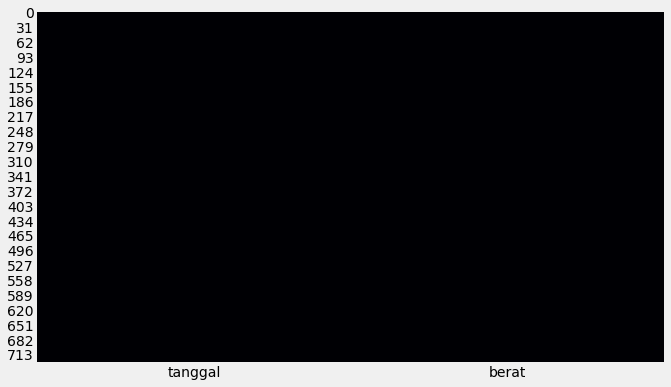

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [7]:
data.describe()

,berat
count,729.00
mean,7490.75
std,2326.39
min,1588.00
25%,5952.00
50%,7457.00
75%,8836.00
max,16929.00


In [8]:
data['Date'] = pd.to_datetime(data['tanggal'])
data = data.drop(columns = 'tanggal')
data = data.set_index('Date')
data = data.rename(columns = {'berat':'berat'})
data.head()

,berat
Date,
2018-01-02,5449
2018-01-03,3636
2018-01-04,4829
2018-01-05,9713
2018-01-06,8706


In [52]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [53]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

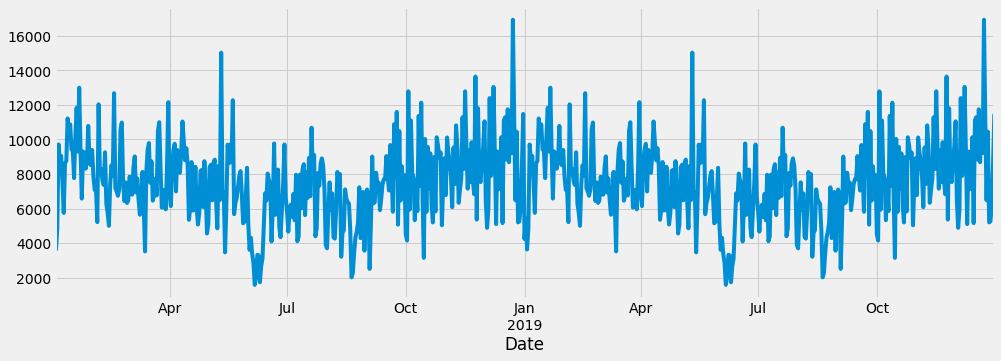

In [54]:
plt.figure(figsize = (15,5))
data['berat'].plot();

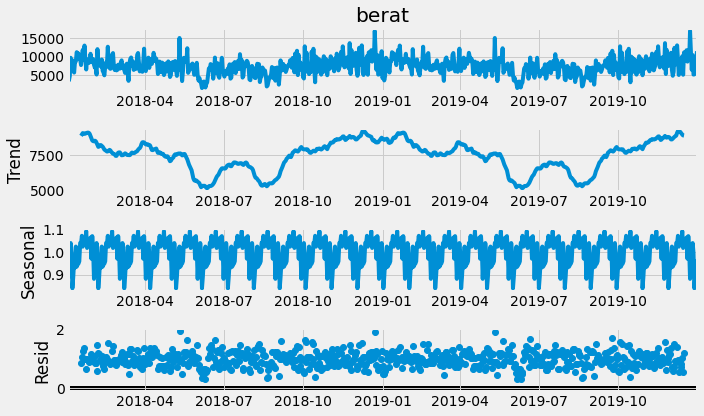

<Figure size 1152x648 with 0 Axes>

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['berat'],period = 30, model = 'multiplicative').plot()
fig = plt.figure()  
# fig = result.plot()  
fig.set_size_inches(16, 9)

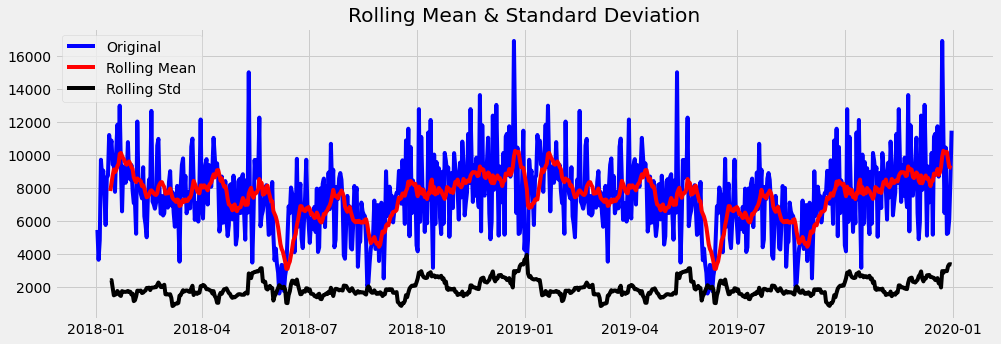

Results of Dickey-Fuller Test:
Test Statistic                 -4.02
p-value                         0.00
#Lags Used                     19.00
Number of Observations Used   709.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [56]:
test_stationarity(data['berat'])

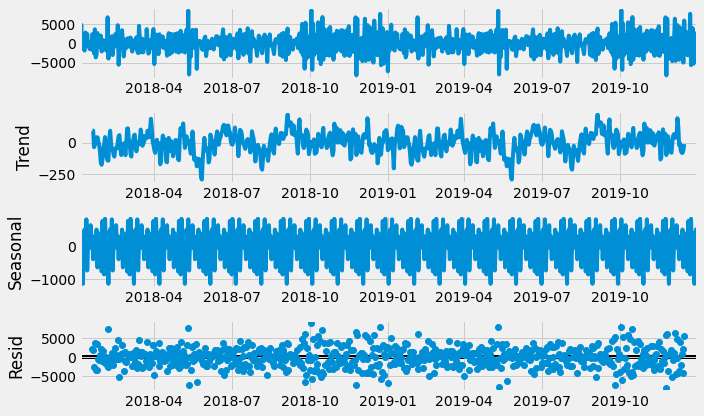

In [57]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 30).plot()
plt.show()

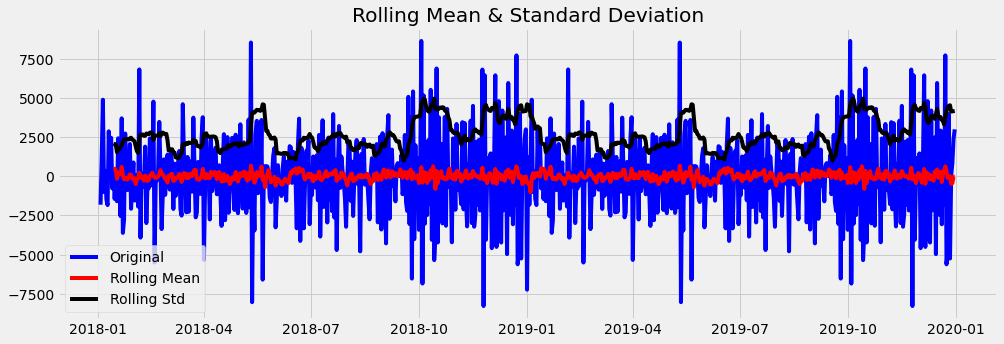

Results of Dickey-Fuller Test:
Test Statistic                 -9.23
p-value                         0.00
#Lags Used                     20.00
Number of Observations Used   707.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [58]:
test_stationarity(data_diff)

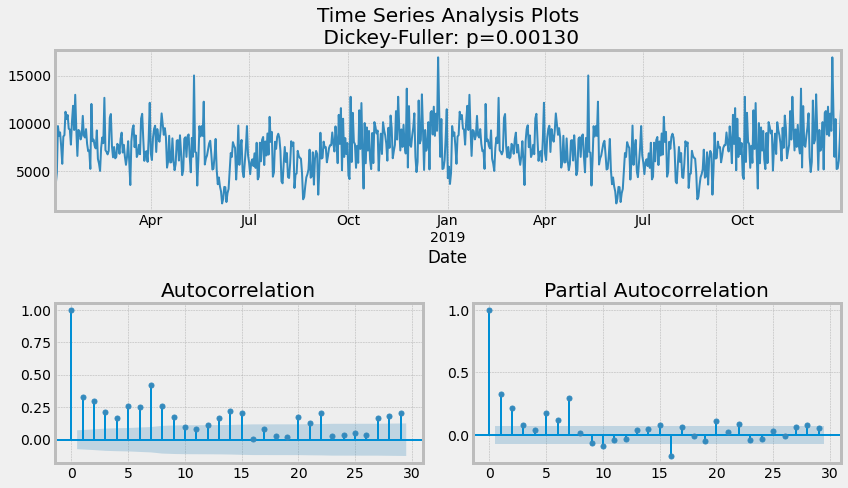

In [59]:
tsplot(data['berat'])

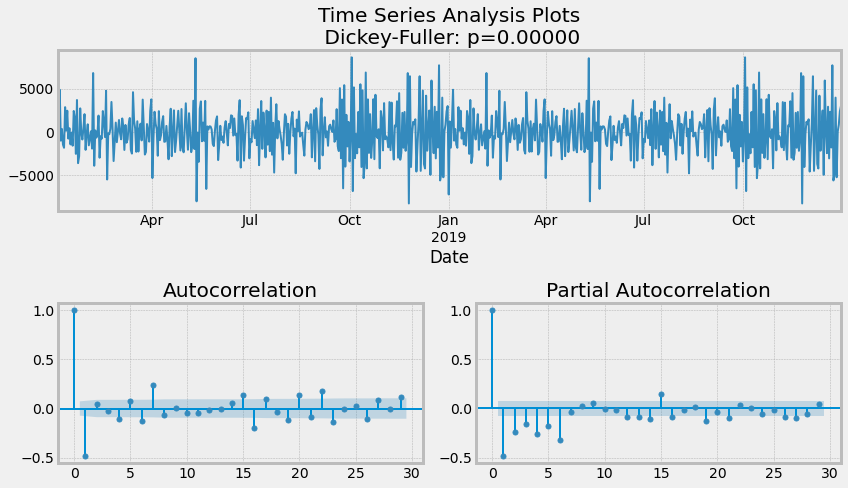

In [60]:
tsplot(data_diff['berat'])

In [61]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(data['berat'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  berat   No. Observations:                  729
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6607.279
Date:                Thu, 15 Dec 2022   AIC                          13224.558
Time:                        12:26:51   BIC                          13247.510
Sample:                    01-02-2018   HQIC                         13233.414
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8382      0.072    -11.580      0.000      -0.980      -0.696
ar.L2          0.0449      0.046      0.974      0.330      -0.045       0.135
ma.L1          0.0600      0.061      0.977      0.3

In [75]:
size = int(len(data) - 30)
train, test = data['berat'][0:size], data['berat'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.arima.ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 9045.306728, expected = 6466.000000
predicted = 8776.075028, expected = 4887.000000
predicted = 7806.079896, expected = 5952.000000
predicted = 7914.173566, expected = 12396.000000
predicted = 8763.529929, expected = 7888.000000
predicted = 8375.869670, expected = 8251.000000
predicted = 8437.396040, expected = 13046.000000
predicted = 9405.093019, expected = 9332.000000
predicted = 9006.247919, expected = 5104.000000


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted = 8327.524402, expected = 9302.000000
predicted = 8745.092545, expected = 7127.000000
predicted = 8259.931616, expected = 7644.000000
predicted = 8318.935401, expected = 10126.000000
predicted = 8647.591256, expected = 5161.000000
predicted = 7842.827266, expected = 11113.000000
predicted = 8853.579802, expected = 11290.000000
predicted = 8902.414441, expected = 8832.000000
predicted = 8992.815358, expected = 11748.000000
predicted = 9424.354732, expected = 8685.000000
predicted = 9150.078866, expected = 11015.000000
predicted = 9647.263054, expected = 9214.000000
predicted = 9316.473474, expected = 16929.000000
predicted = 11156.044155, expected = 11314.000000
predicted = 10376.774850, expected = 6480.000000
predicted = 10057.606019, expected = 10452.000000
predicted = 9976.134204, expected = 5204.000000
predicted = 9161.630796, expected = 5265.000000
predicted = 8572.881773, expected = 6100.000000
predicted = 8317.856844, expected = 8485.000000
predicted = 8493.237996, expe

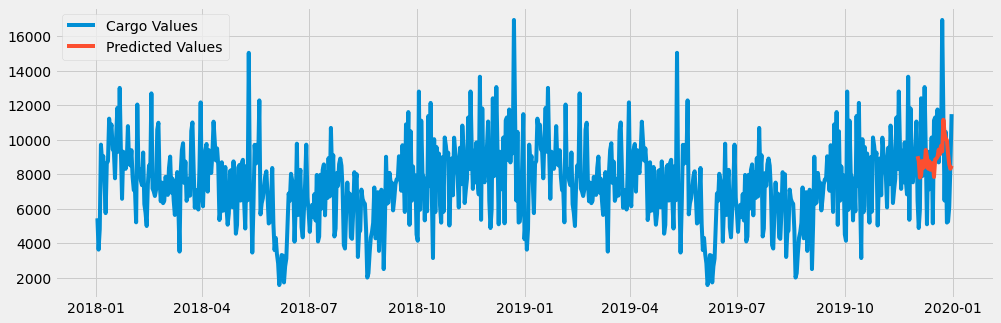

In [76]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['berat'],label = 'Cargo Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [77]:
# error = np.sqrt(mean_squared_error(test,predictions))
# print('Test RMSE: %.4f' % error)

# report performance
mse = mean_squared_error(test,predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test,predictions)
print('MAE: '+str(mae)) 
rmse = np.sqrt(mean_squared_error(test,predictions))
print('RMSE: '+str(rmse))

MSE: 8556486.475343313
MAE: 2293.890742265602
RMSE: 2925.1472570356714


In [78]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(days = x) for x in range(0,30)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2018-01-02,5449,NaN,NaN
2018-01-03,3636,NaN,NaN
2018-01-04,4829,NaN,NaN
2018-01-05,9713,NaN,NaN
2018-01-06,8706,NaN,NaN


In [88]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()[0][0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[729 + i,1] = f1[i]
forecast.tail(30)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2019-12-31,11479,NaN,NaN
2020-01-01,NaN,8994.98,NaN
2020-01-02,NaN,8802.44,NaN
2020-01-03,NaN,8746.05,NaN
2020-01-04,NaN,8689.97,NaN
2020-01-05,NaN,8646.93,NaN
2020-01-06,NaN,8587.02,NaN
2020-01-07,NaN,8538.46,NaN
2020-01-08,NaN,8491.51,NaN
2020-01-09,NaN,8447.75,NaN


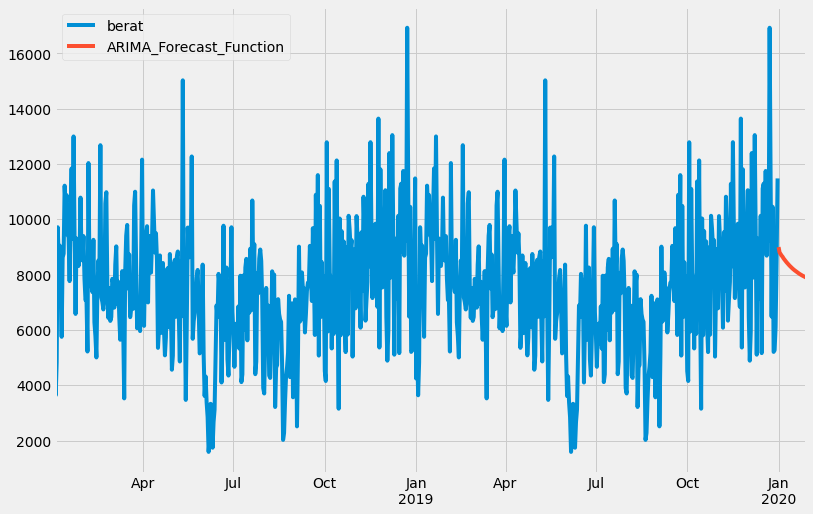

In [90]:
forecast[['berat','ARIMA_Forecast_Function']].plot(figsize = (12,8));

In [96]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = sm.tsa.arima.ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[729 + i,2] = f2[i]
forecast.tail(30)

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2019-12-31,11479,NaN,NaN
2020-01-01,NaN,8994.98,9045.31
2020-01-02,NaN,8802.44,9331.30
2020-01-03,NaN,8746.05,9007.79
2020-01-04,NaN,8689.97,9294.93
2020-01-05,NaN,8646.93,9037.23
2020-01-06,NaN,8587.02,9268.35
2020-01-07,NaN,8538.46,9061.04
2020-01-08,NaN,8491.51,9247.05
2020-01-09,NaN,8447.75,9080.18


In [1]:
forecast[['berat','ARIMA_Predict_Function']].plot(figsize = (10,20));

NameError: name 'forecast' is not defined

In [ ]:
sum(f1) == sum(f2)